In [38]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import linear_model
from math import *
plt.rcParams["figure.figsize"] = (16, 9)

In [24]:
df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv', parse_dates=[0])
df.columns = ['dt', 'avg', 'error', 'country']
first_date = df['dt'][0]
df['ordinal'] = df['dt'].apply(lambda d: d.toordinal())
df.head()

,dt,avg,error,country,ordinal
0,1743-11-01,4.384,2.294,Åland,636557
1,1743-12-01,NaN,NaN,Åland,636587
2,1744-01-01,NaN,NaN,Åland,636618
3,1744-02-01,NaN,NaN,Åland,636649
4,1744-03-01,NaN,NaN,Åland,636678


In [69]:
df = df[df.avg.notnull()]
d1960 = datetime(1960, 1, 1)
d1990 = datetime(1990, 1, 1)
data = df[(d1960 < df['dt']) & (df['dt']< d1990)].groupby('country', as_index=False)['avg'].mean()

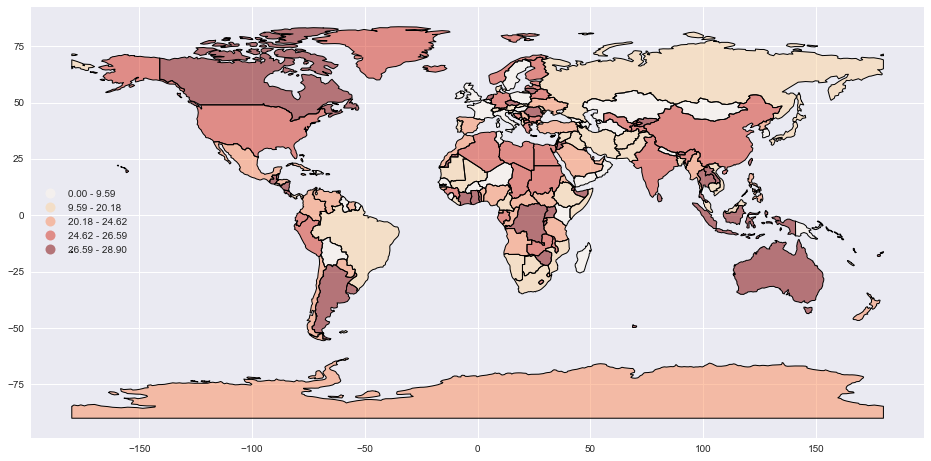

In [89]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
data.set_index('country')
world.set_index('name')
join = world.join(data)
#join[world.avg.notnull()]
join.plot(column='avg', cmap='OrRd', scheme='quantiles', legend=True)